## This notebook outputs a plot of global sensor cadence of Sentinel-1, Sentinel-2, and Landsat8
Inputs are area of interest (Polygon), date range (list of datetimes), and sampling resolution. Default sampling resolution is 1 degree longitude, 0.25 degree latitude.

In [1]:
from IPython.core.display import HTML
HTML("<style>.container { width:98% !important; }</style>")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# GIS imports
from shapely.geometry import Polygon
from opera_coverage import *
import geopandas as gpd
import pandas as pd
from shapely.geometry import box, Point
from rasterio.crs import CRS

# Misc imports
import numpy as np
from itertools import product
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
import concurrent.futures
from typing import List

In [5]:
# helper functions

# wrapper function for get_coverage, returns string if thread crashed while running
def get_cadence_df(geo:Polygon, daterange:List[datetime]):
    results = pd.DataFrame(columns=['startTime','geometry','sensor','fileID'])
    try:
        return get_coverage(['sentinel1','sentinel2','landsat8'], geo, daterange)
    except:
        print('Thread crashed')
        return 'Thread crashed'

# the below two functions help grid the data into 1 degree by 1 degree boxes
def get_lat(geom):
    return int(np.floor(geom.centroid.coords.xy[1][0]))
def get_lon(geom):
    return int(np.floor(geom.centroid.coords.xy[0][0]))

# creates the 1 degree by 1 degree box
def make_box(row):
    return box(row['lon'], row['lat'], row['lon'] + 1, row['lat'] + 1)

For continent geometries use Natural Earth Lowres from Geopandas

In [6]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [7]:
# generate one polygon for Australia
australia_df = world[world.name == 'Australia']
australia_geo = australia_df.geometry.unary_union

In [24]:
# generate one polygon for Europe
europe_df = world[world.continent == 'Europe']
europe_geo = europe_df.geometry.unary_union

In [33]:
# generate one polygon for North America
northamerica_df = world[world.continent == 'North America']
northamerica_geo = northamerica_df.geometry.unary_union

In [37]:
# generate one polygon for South America
southamerica_df = world[world.continent == 'South America']
southamerica_geo = southamerica_df.geometry.unary_union

In [41]:
# generate one polygon for Africa
africa_df = world[world.continent == 'Africa']
africa_geo = africa_df.geometry.unary_union

In [42]:
# generate one polygon for Asia
asia_df = world[world.continent == 'Asia']
asia_geo = asia_df.geometry.unary_union

In [50]:
# generate one polygon for Oceania
oceania_df = world[world.continent == 'Oceania']
oceania_geo = oceania_df.geometry.unary_union

In [8]:
def get_area_coverage(aoi: Polygon, date: List[datetime], x_res = 1, y_res = 0.25, radius = 0.1):

    df_points = grid_intersect(aoi, x_res, y_res, radius)
    results = lookup(df_points, date)
    df_temp = regrid(results)
    df_ag = aggregator(df_temp)
    
    return df_ag

In [9]:
def grid_intersect(aoi: Polygon, x_res, y_res, radius):
    
    x_start, y_start, x_end, y_end = aoi.bounds
    df = make_grid(x_start, y_start, x_end, y_end, x_res, y_res, radius)
    
    indices = df.geometry.intersects(aoi)
    
    return df[indices].reset_index(drop=True)

In [10]:
def lookup(df_points: gpd.GeoDataFrame, daterange) -> gpd.GeoDataFrame:
    df_temp = df_points.copy()
    av_cad_hours = []
    avail_sensors = []
    n_avail_sensors = []
    for i in range(len(df_points) // 200 + 1):
        with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
            results = list(executor.map(get_cadence_df, tqdm(df_points.geometry[(i * 200):(i + 1) * 200]), [daterange] * 200))

            av_cad_hours += [i.cadence.mean().seconds/3600 if type(i) is not str else np.nan for i in results]
#             avail_sensors += [i.sensor.unique() if type(i) is not str else '' for i in results]
            n_avail_sensors += [len(i.sensor.unique()) if type(i) is not str else np.nan for i in results]
            
    df_temp['av_cad_hours'] = av_cad_hours
#     df_temp['avail_sensors'] = avail_sensors
    df_temp['n_avail_sensors'] = n_avail_sensors
                
    return df_temp

In [11]:
def regrid(df_temp: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    # Re-grid results to 1x1 degree cells
    df_temp['lon'] = df_temp.geometry.map(get_lon)
    df_temp['lat'] = df_temp.geometry.map(get_lat)
    
    return df_temp

In [19]:
def aggregator(df_temp: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    df_ag = df_temp.groupby(['lon', 'lat']).mean().reset_index()
    geom = df_ag.apply(make_box, axis=1)
    df_ag = gpd.GeoDataFrame(df_ag,
                             geometry=geom,
                             crs = CRS.from_epsg(4326))
    return df_ag

In [13]:
def make_grid(x_start, y_start, x_end, y_end, x_res = 1, y_res = 0.25, radius = 0.1):
    lon_lat = list(product(
                np.linspace(x_start + (x_res/2), x_end - (x_res/2), int((x_end - x_start) / x_res)), 
                np.linspace(y_start + (y_res/2), y_end - (y_res/2), int((y_end - y_start) / y_res))
                ))

    geometry = [Point(lon, lat).buffer(radius) for lon, lat in lon_lat]

    center_x = [lon for lon, _ in lon_lat]
    center_y = [lat for _, lat in lon_lat]

    df = gpd.GeoDataFrame({'center_x':center_x, 'center_y':center_y}, geometry = geometry, crs=CRS.from_epsg(4326))
    
    return df

In [21]:
%%time
df = get_area_coverage(australia_geo,[datetime(2022,1,1),datetime(2022,2,1)],y_res = 1)

100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 4637.87it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


100%|██████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 2889.32it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

CPU times: user 2min 10s, sys: 34.2 s, total: 2min 44s
Wall time: 7min 13s


In [22]:
df

,lon,lat,center_x,center_y,av_cad_hours,n_avail_sensors,geometry
0,113,-27,113.838953,-26.635804,21.298056,2.0,"POLYGON ((114.00000 -27.00000, 114.00000 -26.0..."
1,113,-25,113.838953,-24.573455,3.428333,2.0,"POLYGON ((114.00000 -25.00000, 114.00000 -24.0..."
2,113,-24,113.838953,-23.542281,3.428333,2.0,"POLYGON ((114.00000 -24.00000, 114.00000 -23.0..."
3,113,-23,113.838953,-22.511106,23.999722,2.0,"POLYGON ((114.00000 -23.00000, 114.00000 -22.0..."
4,114,-29,114.844864,-28.698153,19.188889,2.0,"POLYGON ((115.00000 -29.00000, 115.00000 -28.0..."
...,...,...,...,...,...,...,...
683,153,-30,153.069469,-29.729328,15.709167,3.0,"POLYGON ((154.00000 -30.00000, 154.00000 -29.0..."
684,153,-29,153.069469,-28.698153,10.400278,3.0,"POLYGON ((154.00000 -29.00000, 154.00000 -28.0..."
685,153,-28,153.069469,-27.666979,9.371667,3.0,"POLYGON ((154.00000 -28.00000, 154.00000 -27.0..."
686,153,-27,153.069469,-26.635804,22.273611,3.0,"POLYGON ((154.00000 -27.00000, 154.00000 -26.0..."


In [23]:
df.to_file('Australia 687')

/var/folders/hs/wfv_gwl12y740vc3gk80q82h0000gq/T/ipykernel_8621/2835263052.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df.to_file('Australia 687')


In [ ]:
%%time
df = get_area_coverage(europe_geo,[datetime(2022,1,1),datetime(2022,2,1)],y_res = 1)
beepy.beep(sound=5)

100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 8328.15it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn

/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1730.85it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn(

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashedThread crashed

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 8258.70it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashedThread crashed

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 8236.16it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn(

Thread crashedThread crashed

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3142.58it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 5362.94it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashedThread crashed

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 6045.93it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2646.59it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashedThread crashed

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashedThread crashed

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 5532.65it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashedThread crashed

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 5214.46it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashedThread crashed

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


100%|███████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 11306.01it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


In [26]:
len(df)

3868

In [27]:
df.to_file('Europe 3868')

/var/folders/hs/wfv_gwl12y740vc3gk80q82h0000gq/T/ipykernel_8621/4205959376.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df.to_file('Europe 3868')


In [32]:
import beepy
beepy.beep(sound=5)

In [34]:
%%time
df1 = get_area_coverage(northamerica_geo,[datetime(2022,1,1),datetime(2022,2,1)],y_res = 1)
beepy.beep(sound=5)

100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 9568.50it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera

/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn

/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn(

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3401.13it/s]


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashedThread crashed

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashedThread crashed
Thread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3911.99it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 6814.02it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 8598.06it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


100%|███████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 10531.18it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  war

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 6796.03it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_cov

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  war

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn(

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  war

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 5279.54it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  war

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn(

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn

/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  war

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 3908.21it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_c

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
CPU times: user 10min 53s, sys: 2min 25s, total: 13min 18s
Wall time: 36min 17s


In [35]:
len(df1)

3854

In [36]:
df1.to_file('N Amer 3854')

/var/folders/hs/wfv_gwl12y740vc3gk80q82h0000gq/T/ipykernel_8621/2280291351.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df1.to_file('N Amer 3854')


In [38]:
%%time
df2 = get_area_coverage(southamerica_geo,[datetime(2022,1,1),datetime(2022,2,1)],y_res = 1)
beepy.beep(sound=5)

100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 6939.56it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
100%|███████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 11541.84it/s]
/Users/angelac/ope

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 9928.52it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


100%|█████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 886.37it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

100%|███████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 10330.03it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_c

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7519.57it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn(

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

CPU times: user 5min 5s, sys: 1min, total: 6min 6s
Wall time: 16min 15s


In [39]:
len(df2)

1551

In [40]:
df2.to_file('S Amer 1551')

/var/folders/hs/wfv_gwl12y740vc3gk80q82h0000gq/T/ipykernel_8621/3889617379.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df2.to_file('S Amer 1551')


In [43]:
%%time
df3 = get_area_coverage(africa_geo,[datetime(2022,1,1),datetime(2022,2,1)],y_res = 1)
beepy.beep(sound=5)

100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 9735.18it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 9813.07it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 8883.79it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
100%|███████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 11613.74it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 9823.30it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  war

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 6110.23it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7941.50it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashedThread crashed
Thread crashed

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashedThread crashed

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

KeyboardInterrupt: 

In [44]:
len(df3)

2557

In [45]:
df3.to_file('Africa 2557')

/var/folders/hs/wfv_gwl12y740vc3gk80q82h0000gq/T/ipykernel_8621/246746214.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df3.to_file('Africa 2557')


In [46]:
df4 = get_area_coverage(asia_geo,[datetime(2022,1,1),datetime(2022,2,1)],y_res = 1)

100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 8378.39it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  war

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 6713.20it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_c

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 6276.88it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 6307.56it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3718.24it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_cov

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  war

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

100%|███████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 10343.79it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed


In [48]:
len(df4)

3107

In [49]:
df4.to_file('Asia 3107')

/var/folders/hs/wfv_gwl12y740vc3gk80q82h0000gq/T/ipykernel_8621/1228760143.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df4.to_file('Asia 3107')


In [52]:
df5 = get_area_coverage(oceania_geo,[datetime(2022,1,1),datetime(2022,2,1)],y_res = 1)
beepy.beep(sound=5)

100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1998.34it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn(

Thread crashed


100%|████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 5699.35it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

AttributeError: 'NoneType' object has no attribute 'bounds'

In [55]:
len(df5)

790

In [56]:
df5.to_file('Oceania 790')

/var/folders/hs/wfv_gwl12y740vc3gk80q82h0000gq/T/ipykernel_8621/1249661340.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df5.to_file('Oceania 790')


ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: Invalid coordinate
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: Invalid coordinate
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: Invalid coordinate
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: Invalid coordinate
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: Invalid coordinate
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: Invalid coordinate
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: Invalid coordinate
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: Invalid coordinate
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: Invalid coordinate
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: Invalid coordinate
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: Invalid coordinate
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: Invalid coordinate
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: Invalid coordinate
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: Invalid coordinate
ERROR 1: PROJ: webmerc: Invalid la

KeyboardInterrupt: 

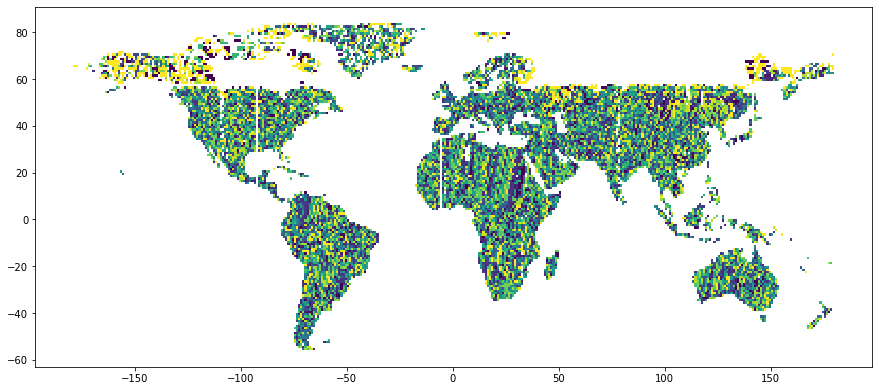

In [78]:
import matplotlib.pyplot as plt
import contextily as cx
from rasterio.crs import CRS

fig, ax = plt.subplots(figsize=(15,15))
df.plot(column='av_cad_hours', ax = ax)
df1.plot(column='av_cad_hours', ax = ax)
df2.plot(column='av_cad_hours', ax = ax)
df3.plot(column='av_cad_hours', ax = ax)
df4.plot(column='av_cad_hours', ax = ax)
df5.plot(column='av_cad_hours', ax = ax)
cx.add_basemap(ax, crs=CRS.from_epsg(4326), zoom = 10)

In [79]:
df.set_crs('EPSG:4326')

,lon,lat,center_x,center_y,av_cad_hours,n_avail_sensors,geometry
0,-180,66,-179.5,66.715039,NaN,NaN,"POLYGON ((-179.00000 66.00000, -179.00000 67.0..."
1,-180,67,-179.5,67.717565,NaN,NaN,"POLYGON ((-179.00000 67.00000, -179.00000 68.0..."
2,-180,68,-179.5,68.720091,NaN,NaN,"POLYGON ((-179.00000 68.00000, -179.00000 69.0..."
3,-179,65,-178.5,65.712513,23.999722,1.0,"POLYGON ((-178.00000 65.00000, -178.00000 66.0..."
4,-179,66,-178.5,66.715039,NaN,NaN,"POLYGON ((-178.00000 66.00000, -178.00000 67.0..."
...,...,...,...,...,...,...,...
3863,179,65,179.5,65.712513,23.999722,1.0,"POLYGON ((180.00000 65.00000, 180.00000 66.000..."
3864,179,66,179.5,66.715039,NaN,NaN,"POLYGON ((180.00000 66.00000, 180.00000 67.000..."
3865,179,67,179.5,67.717565,NaN,NaN,"POLYGON ((180.00000 67.00000, 180.00000 68.000..."
3866,179,68,179.5,68.720091,NaN,NaN,"POLYGON ((180.00000 68.00000, 180.00000 69.000..."


In [ ]:
import numpy as np
from matplotlib import ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors, colorbar
import matplotlib.pyplot as plt
import geopandas as gpd

"""
Source:
https://scitools.org.uk/cartopy/docs/latest/_modules/cartopy/mpl/gridliner.html
"""
_DEGREE_SYMBOL = ''

df_land = gpd.read_file('natural_earth/ne_50m_land')
df_ocean = gpd.read_file('natural_earth/ne_50m_ocean')
df_coastline = gpd.read_file('natural_earth/ne_50m_coastline')


def _fix_lons(lons):
    """
    Fix the given longitudes into the range ``[-180, 180]``.
    """
    lons = np.array(lons, copy=False, ndmin=1)
    fixed_lons = ((lons + 180) % 360) - 180
    # Make the positive 180s positive again.
    fixed_lons[(fixed_lons == -180) & (lons > 0)] *= -1
    return fixed_lons


def _lon_heimisphere(longitude):
    """Return the hemisphere (E, W or '' for 0) for the given longitude."""
    longitude = _fix_lons(longitude)
    if longitude > 0:
        hemisphere = 'E'
    elif longitude < 0:
        hemisphere = 'W'
    else:
        hemisphere = ''
    return hemisphere


def _lat_heimisphere(latitude):
    """Return the hemisphere (N, S or '' for 0) for the given latitude."""
    if latitude > 0:
        hemisphere = 'N'
    elif latitude < 0:
        hemisphere = 'S'
    else:
        hemisphere = ''
    return hemisphere


def _east_west_formatted(longitude, num_format='g'):
    fmt_string = u'{longitude:{num_format}}{degree}{hemisphere}'
    return fmt_string.format(longitude=abs(longitude), num_format=num_format,
                             hemisphere=_lon_heimisphere(longitude),
                             degree=_DEGREE_SYMBOL)


def _north_south_formatted(latitude, num_format='g'):
    fmt_string = u'{latitude:{num_format}}{degree}{hemisphere}'
    return fmt_string.format(latitude=abs(latitude), num_format=num_format,
                             hemisphere=_lat_heimisphere(latitude),
                             degree=_DEGREE_SYMBOL)


#: A formatter which turns longitude values into nice longitudes such as 110W
LONGITUDE_FORMATTER = mticker.FuncFormatter(lambda v, pos:
                                            _east_west_formatted(v))


#: A formatter which turns longitude values into nice longitudes such as 45S
LATITUDE_FORMATTER = mticker.FuncFormatter(lambda v, pos:
                                           _north_south_formatted(v)
                                           )


def update_format_to_cartopy(ax,  fs=10):
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=fs)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=fs)

    ax.set_xlabel('Longitude', weight='bold', zorder=2, fontsize=fs)
    ax.set_ylabel('Latitude', weight='bold', zorder=2, fontsize=fs)

    ax.xaxis.set_ticks(np.arange(-180, 181, 60))
    ax.yaxis.set_ticks(np.arange(-90, 91, 30))

    ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
    ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)

    df_land.plot(ax=ax, facecolor='#A9A9A9', zorder=0)
    df_ocean.plot(ax=ax, facecolor='#ADD8E6', zorder=0)
    df_coastline.plot(ax=ax,
                      facecolor=(0, 0, 0, 0),
                      edgecolor='black',
                      lw=.2,
                      zorder=0)

    return ax


def make_colorbar(ax,
                  colorbar_label,
                  vmin, vmax,
                  cmap='viridis',
                  fs=10
                  ):

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3.5%', pad=0.07)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    colorbar.ColorbarBase(cax,
                          cmap=plt.get_cmap(cmap),
                          norm=norm,
                          orientation='vertical')
    cax.set_ylabel(colorbar_label,
                   fontsize=fs)
    cax.tick_params(axis='both',
                    which='major',
                    labelsize=fs)
    return cax

In [ ]:
vmin=0
vmax=2
cmap = 'tab20b'
FS=12

fig, ax = plt.subplots(figsize=(12, 6), dpi=DPI)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, facecolor='white', edgecolor='black', alpha=.25)
gdf_square_season_final.plot(column='season_best', 
                             cmap=cmap,
                             ax=ax,
                             categorical=True,
                             legend=True,
                             legend_kwds={'fontsize':FS,
                                          'title':"Season",
                                          'loc': 'lower left',
                                          'title_fontsize': FS})

ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)

update_format_to_cartopy(ax, fs=FS)

fig_name = f'{MODEL}_{delay_time_csv}_year-{YEAR_S}_season-{SEASON_S}_best-season.{FORMAT}'
plt.savefig(figure_dir/fig_name, format=FORMAT)

print(fig_name)